# Building your first Artificial Neural Network with AWS

#### Predicting fashion type using Zalando's Fasion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist)

***
Copyright [2017]-[2017] Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"). You may not use this file except in compliance with the License. A copy of the License is located at

http://aws.amazon.com/apache2.0/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
***

### Load dependencies

In [1]:
import mxnet as mx
import mxnet.notebook.callback
import numpy as np
import os
#import urllib  # for Python 2
import urllib.request  # for Python 3
import gzip
import struct
import math
import cv2
import scipy.misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Prepare training and test datasets
`download_data` downloads data from a given `url`, if no file with the same name has been downloaded so far,  
`to4d` reshapes data, adding one axis of length 1 and normalizes the entries to [0,1],  
`read_data` creates labels and datasets from the corresponding .gz files.

With these functions we download data from GitHub, create training/test datasets/labels and then split them into batches of size 100 (shuffle for training).  
Dataset gets the name `'fashion_data'`, labels - `'fashion_item_label'`

In [2]:
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
    return fname

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

def read_data(label, image):
    base_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/'
    with gzip.open(download_data(base_url+label, os.path.join('data',label))) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(base_url+image, os.path.join('data',image)), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

batch_size = 100
(train_lbl, train_img) = read_data('train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data('t10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')
train_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(train_img)}, label= {'fashion_item_label': train_lbl}, batch_size=batch_size, shuffle=True)
test_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(val_img)}, label= {'fashion_item_label': val_lbl}, batch_size=batch_size)

### Display example training data

The original Fashion-MNIST consists of 28x28 grayscale images.

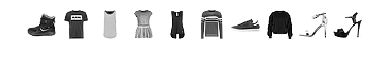

label: [9 0 0 3 0 2 7 2 5 5]


In [3]:
for i in range(10):
    plt.subplot(1,10,i+1)
    dsp_img= train_img[i]
    plt.imshow(dsp_img, cmap='Greys')
    plt.axis('off')

plt.show()
print('label: %s' % (train_lbl[0:10],))

Each training and test example is assigned to the labels from 0 to 9, here is what the numeric labels correspond to:

In [4]:
fashion_labels=['T-shirt/top',
'Trouser',
'Pullover',
'Dress',
'Coat',
'Sandal',
'Shirt',
'Sneaker',
'Bag',
'Ankle boot']

### Build MXNet model

For building our NN we will use Symbol API, an interface for symbolic programming.

First, we create two placeholders for labels and data inputs with `mx.sym.Variable` and give them names`'fashion_item_label'` and `'fashion_data'` correspondingly. On the next step the data will be flatten to 2-D.

In [5]:
fashion_item_label = mx.sym.Variable('fashion_item_label')
# input
data = mx.symbol.Variable('fashion_data')
# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data=data, name='flatten')

`Symbol` also supports a rich set of neural network layers. The folowing code constructs a 3-layer fully connected neural network with the 1st hidden layer having 128 neurons, the 2nd hidden layer having 64 neurons, both activated by ReLU activation function and softmax output layer `mlp`.

Then we visualize the structure of that network with `mx.viz.plot_network`.

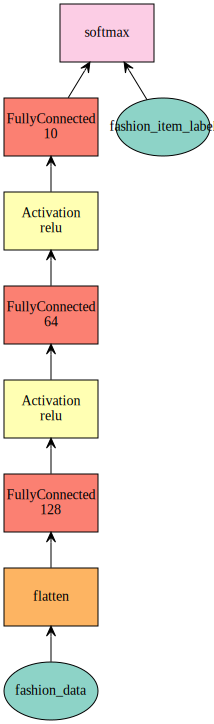

In [6]:
# 1st fully-connected layer + activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

# 2nd fully-connected layer + activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

# 3rd fully connected layer (MNIST uses 10 classes)
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10)

# softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data = fc3, label = fashion_item_label, name='softmax')

mx.viz.plot_network(mlp)

### Train the model and commit checkpoints

First, set up logging and the context (now CPU is used).

In [7]:
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

ctx = mx.cpu()  # for GPU change to mx.gpu()

MXNet modularizes commonly used code for training and inference in the `module` (`mod` for short) package.

We can construct a module by specifying the following parameters:

- `symbol`: the network definition (`mlp` in our case)
- `context`: the device (or a list of devices) to use for execution (`ctx` in our case)
- `data_names` : the list of input data variable names (`'fashion_data'` in our case)
- `label_names` : the list of input label variable names (`'fashion_item_label'` in our case)

In [8]:
mod = mx.mod.Module(symbol=mlp, data_names=['fashion_data'], label_names=['fashion_item_label'], context=ctx, logger=logging)

 `Module` provides both high-level and intermediate-level interfaces for executing predefined networks. We will use a high-level-interface function [`mod.fit`](http://mxnet.io/api/python/module.html#mxnet.module.BaseModule.fit) to train the model, which internally executes the following steps:
 
- `bind` : Prepares environment for the computation by allocating memory.
- `init_params` : Assigns and initializes parameters.
- `init_optimizer` : Initializes optimizers. Defaults to `sgd`.
- `metric.create` : Creates evaluation metric from input metric name.
- `forward` : Forward computation.
- `update_metric` : Evaluates and accumulates evaluation metric on outputs of the last forward computation.
- `backward` : Backward computation.
- `update` : Updates parameters according to the installed optimizer and the gradients computed in the previous forward-backward batch.

We will save checkpoints for each epoch in "fashion_mnist-epoch№.params".

**NOTE**: If you want to initialize parameters in a certain way, use the commented  intermediate-level-interface functions: `mod.bind` and `mod.init_params` and set `force_init = False` in `mod.fit`. In this case `mod.fit` will raise a warning, that since parameters are already initialized, init_params call is ignored.

In [9]:
#mod.bind(data_shapes=train_data_iter.provide_data, label_shapes=train_data_iter.provide_label)
#mod.init_params(initializer=mx.init.Xavier(magnitude=2.))
                        
mod.fit(train_data_iter,                            # train data
        eval_data=test_data_iter,                   # validation data
        optimizer='sgd',                            # use SGD to train
        optimizer_params={'learning_rate' : 0.1},   # use fixed learning rate
        eval_metric=mx.metric.Accuracy(),           # report accuracy during training
        num_epoch=10,                               # train for at most 10 dataset passes
        epoch_end_callback = mx.callback.do_checkpoint('fashion_mnist'), 
        force_rebind = True,
        force_init = True) 

INFO:root:Epoch[0] Train-accuracy=0.306983
INFO:root:Epoch[0] Time cost=1.561
INFO:root:Saved checkpoint to "fashion_mnist-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.661300
INFO:root:Epoch[1] Train-accuracy=0.713733
INFO:root:Epoch[1] Time cost=1.511
INFO:root:Saved checkpoint to "fashion_mnist-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.772600
INFO:root:Epoch[2] Train-accuracy=0.800017
INFO:root:Epoch[2] Time cost=1.751
INFO:root:Saved checkpoint to "fashion_mnist-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.811900
INFO:root:Epoch[3] Train-accuracy=0.829600
INFO:root:Epoch[3] Time cost=1.369
INFO:root:Saved checkpoint to "fashion_mnist-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.829500
INFO:root:Epoch[4] Train-accuracy=0.845233
INFO:root:Epoch[4] Time cost=1.351
INFO:root:Saved checkpoint to "fashion_mnist-0005.params"
INFO:root:Epoch[4] Validation-accuracy=0.836300
INFO:root:Epoch[5] Train-accuracy=0.855033
INFO:root:Epoch[5] Time cost=1.357
IN

### Run predictions for 10 example elements

To predict with `module`, we, first, prepare a dataset for prediction and then call `mod.predict`. It will collect and
return all the prediction results.

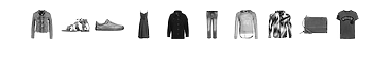

Predicted fashion label for image 10 is [4] (Coat)
Predicted fashion label for image 11 is [5] (Sandal)
Predicted fashion label for image 12 is [7] (Sneaker)
Predicted fashion label for image 13 is [3] (Dress)
Predicted fashion label for image 14 is [4] (Coat)
Predicted fashion label for image 15 is [1] (Trouser)
Predicted fashion label for image 16 is [2] (Pullover)
Predicted fashion label for image 17 is [4] (Coat)
Predicted fashion label for image 18 is [8] (Bag)
Predicted fashion label for image 19 is [0] (T-shirt/top)


In [10]:
pred_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(val_img)[0:100]}, batch_size=100)
pred_digits = mod.predict(eval_data=pred_data_iter).asnumpy()

%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(val_img[i + 10], cmap='Greys')
    plt.axis('off')
plt.show()

for x in range(10, 20):
    label = np.where(pred_digits[x,0:10] == pred_digits[x,0:10].max())[0]
    print("Predicted fashion label for image %s is %s (%s)" % (x, label, fashion_labels[label[0]]))

### Downloading images for prediction from amazon.com

In [11]:
urllib.request.urlretrieve('https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg', 'predict1.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg', 'predict2.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/41hWhZBIc3L._AC_UL260_SR200,260_.jpg', 'predict3.jpg')

('predict3.jpg', <http.client.HTTPMessage at 0x1ff06514fd0>)

### Load model from checkpoint for prediction

To load the saved module parameters, call the `mx.mod.load_checkpoint` function. It loads the symbolic definition of NN and all the associated parameters. We can then set the loaded parameters into the module.

In [12]:
prediction_model_check_point = 10
prediction_model_prefix = 'fashion_mnist'
prediction_sym, arg_params, aux_params = mx.model.load_checkpoint(prediction_model_prefix, prediction_model_check_point)
prediction_model = mx.mod.Module(symbol=prediction_sym, data_names=['fashion_data'], label_names=['fashion_item_label'])

Now we need to bind the model with new data- and label shapes and restore the parameter values. Since we want to make predictions for one image at a time, the data shape now must be (1,1,28,28), label shape - (1,)

In [13]:
prediction_model.bind(for_training=False, data_shapes=[('fashion_data', (1,1,28,28))], label_shapes = [('fashion_item_label', (1,))])
prediction_model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

Now we define the **prediction function** `predict_fashion`, which:
- takes image as an input
- formats it to the needed shape (1, 28, 28), since now it must be a one-element dataset
- creates a trivial data iterator of batch size 1
- makes and prints predictions

In [14]:
def predict_fashion(img):
    # format data to run prediction
    array = np.full((1, 28, 28), img, dtype=np.float32)
    pred_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(array)}, batch_size=1)
    pred_digits = prediction_model.predict(eval_data=pred_data_iter).asnumpy()
    label = (np.where(pred_digits[0] == pred_digits[0].max())[0])
    print("Predicted fashion label for image is %s (%s)  " % (label,fashion_labels[label[0]]))

### Predict labels for downloaded images

Here we first load the image and then adjust it to the colours (with help of bit-wise inversion `cv2.bitwise_not` ) and to the size (with `skimage.transform.resize`) of the training dataset

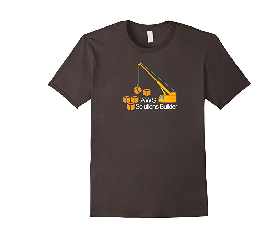

Predicted fashion label for image is [0] (T-shirt/top)  


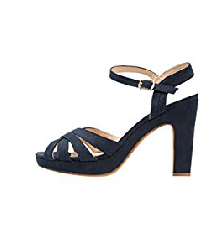

Predicted fashion label for image is [5] (Sandal)  


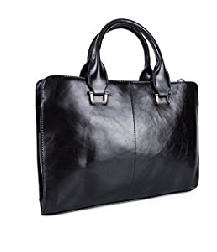

Predicted fashion label for image is [8] (Bag)  


In [15]:
import skimage.transform

for i in range(3):
        img = mpimg.imread('predict'+str(i+1)+'.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show() 
        # get colours in line with train data
        img = cv2.bitwise_not(img)
        img = np.array (np.mean(img, -1))

        # resize image
        img = skimage.transform.resize(img, (28, 28), mode ='reflect')

        predict_fashion(img)